In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
import tensorflow as tf
import h5py, os, yaml
import umap.umap_ as umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
# !pip install https://github.com/p-koo/tfomics/tarball/master
import tfomics
from test_to_bw_fast import read_model, get_config
import pandas as pd
import matplotlib.patches as patches
from tensorflow import keras
import plotly.express as px
import tfr_evaluate, util
import subprocess
import explain
from scipy.stats import pearsonr
from tqdm import tqdm
import glob
import embed

In [39]:
testset, targets = tfr_evaluate.collect_whole_testset(coords=True)

threshold = 2
cell_line = 8
thresholded_C, thresholded_X, thresholded_Y = embed.threshold_cell_line_testset(testset, cell_line)
idr_class = embed.label_idr_peaks(thresholded_C, cell_line)

thresholded_Y.shape



(12818, 2048)

In [40]:
run_paths = []
run_paths.append(('/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/shush/wandb/wandb_bizon/run-20210705_124947-5lmwz5d3', -3))# 32
run_paths.append(('../'+'paper_runs/new_models/32_res/run-20211023_095131-w6okxt01', -3)) # residual 32 exp



In [46]:
# model_id_embeddings = {}
for run_path, layer in [run_paths[2]]:
    model, bin_size = read_model(run_path, compile_model=False)
    aux_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[layer].output)
    model_id = embed.describe_run(run_path, ['model_fn', 'bin_size'])
    interm_representations = embed.predict_np(thresholded_X, aux_model, 
                                              batch_size=32, reshape_to_2D=True)
    embeddings = embed.get_embeddings(interm_representations)
    embeddings['IDR'] = idr_class
    embeddings['cell line'] = targets[cell_line]
    model_id_embeddings[model_id] = embeddings

In [47]:
all_df = []
for model_id, embeddings in model_id_embeddings.items():
    embeddings['model'] = model_id.split(' ')[1]
    all_df.append(embeddings)
all_embeddings = pd.concat(all_df)

<Figure size 2160x1440 with 0 Axes>

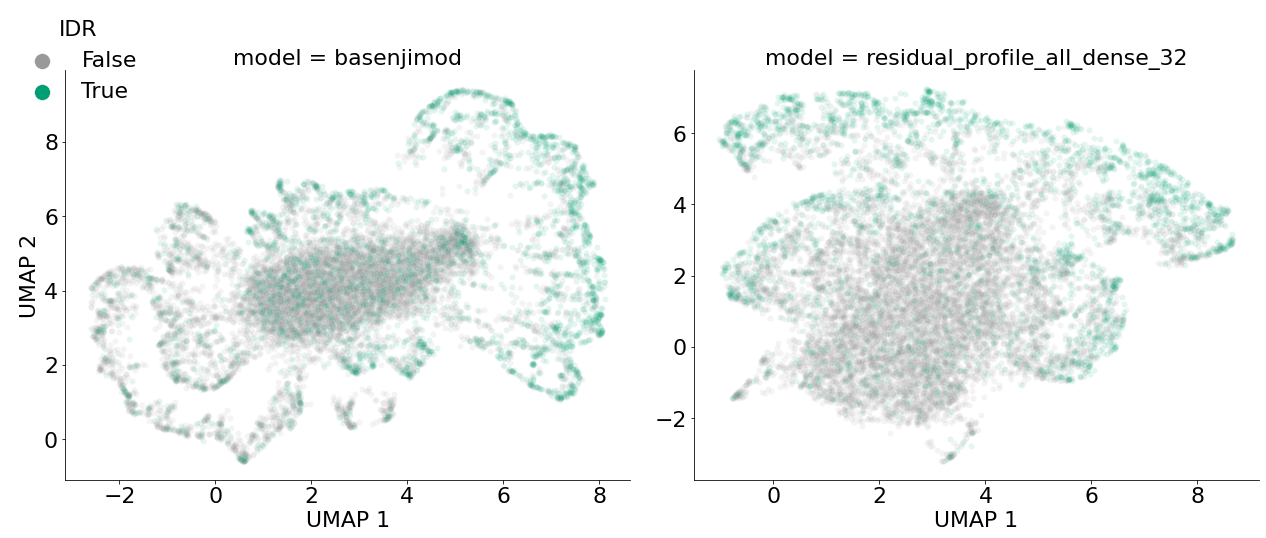

In [48]:
plt.figure(figsize=[30,20])
plt.rcParams.update({'font.size': 22})

g = sns.FacetGrid(all_embeddings, hue="IDR",col='model', 
                  height=8, palette=['#999999', '#009E73'], sharex=False, sharey=False) #'#05F31A'
g.map(sns.scatterplot, "UMAP 1", "UMAP 2", alpha=0.1)
g.add_legend(loc='upper left')
for lh in g._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [250] 

    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])